### Student Number : 2
#### Alexandre Lemonnier (alexandre.lemonnier) (23077)
#### Victor Simonin (victor.simonin) (23093)

First, let's import our useful libraries

In [126]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, isnull, mean, abs, max
from datetime import timedelta
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import pandas as pd

In [104]:
spark_application_name = "Projet_LAVS"
spark = (SparkSession.builder.appName(spark_application_name).getOrCreate())

Here we define the structure of the schema and its columns with their relative types

In [105]:
columns = [StructField("Date",TimestampType()), StructField("High",FloatType()), StructField("Low",FloatType()), StructField("Open",FloatType()), StructField("Close",FloatType()), StructField("Volume",IntegerType()), StructField("Adj Close",FloatType()), StructField("company_name",StringType())]
schema = StructType(columns)

def read_data(path):
    return spark.read.schema(schema).csv(path, header=True, sep=',')

In [130]:
amazon = read_data('data/AMAZON.csv')
apple = read_data('data/APPLE.csv')
facebook = read_data('data/FACEBOOK.csv')
google = read_data('data/GOOGLE.csv')
microsoft = read_data('data/MICROSOFT.csv')
tesla = read_data('data/TESLA.csv')
zoom = read_data('data/ZOOM.csv')

Now let's do the exploration of our datasets :

In [107]:
def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(fig_no)
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix for Specified Attributes")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()

In [108]:
def exploration(dataset):
    print("Exploration of the dataset", dataset.head().company_name)
    '''
    print("\nThe 40 first elements : ")
    for el in dataset.head(40):
        print(el)
        
    print("\nThe 40 Last elements : ")
    for el in dataset.tail(40):
        print(el)
    ''' 
        
    print("\nThe total number of observations is", dataset.count())
   
    print("\nThe first date is", dataset.head().Date)
    print("The second date is", dataset.head(2)[1].Date)
    delta = dataset.head(2)[1].Date - dataset.head().Date 
    print(f"So we deduce the period between the data points is {delta}")
    
    print("\nSome statistics :")
    dataset.summary().show()
    
    dataset.select([count(when(isnull(c), c)).alias(c) for c in dataset.columns]).show()
    
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], outputCol=vector_col)
    df_vector = assembler.transform(dataset).select(vector_col)

    # get correlation matrix
    matrix = Correlation.corr(df_vector, vector_col)
    cor_np = matrix.collect()[0][matrix.columns[0]].toArray()
    plot_corr_matrix(cor_np, ['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], 234)

Exploration of the dataset AMAZON

The total number of observations is 987

The first date is 2017-01-03 00:00:00
The second date is 2017-01-04 00:00:00
So we deduce the period between the data points is 1 day, 0:00:00

Some statistics :
+-------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------+
|summary|              High|               Low|             Open|             Close|           Volume|         Adj Close|company_name|
+-------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------+
|  count|               987|               987|              987|               987|              987|               987|         987|
|   mean|1762.0071216958152|1722.1011452099956|1743.433881363487|1742.9566644206718| 4509728.05775076|1742.9566644206718|        null|
| stddev| 667.2385315752688| 644.7988093382758|657.1153070927137| 655.9576061129322|217

/usr/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/tmp/ipykernel_124853/3716359873.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+attr)
/tmp/ipykernel_124853/3716359873.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+attr)


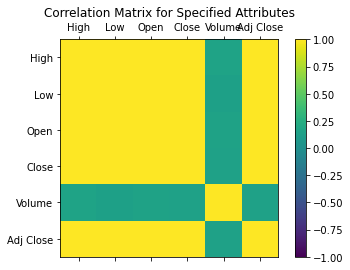

In [109]:
exploration(amazon)

In [148]:
def average_opening_closing(dataset, type=None, beginDate=None):
    if not beginDate:
        beginDate = dataset.head().Date
    if type == "week":
        dd = dataset.select('Open', 'Close').filter(dataset.Date < beginDate + timedelta(weeks=1))
    elif type == "month":
        dd = dataset.select('Open', 'Close').filter(dataset.Date < beginDate + timedelta(weeks=4))
    elif type == "year":
        dd = dataset.select('Open', 'Close').filter(dataset.Date < beginDate + timedelta(weeks=52))
    else:
        dd = dataset.select('Open', 'Close')
    dd = dd.withColumn('Result', abs(dataset['Close'] - dataset['Open']))
    dd.select((mean('Result'))).show()

In [149]:
average_opening_closing(amazon, type="year", beginDate=amazon.head(50)[-1].Date)

+-----------------+
|      avg(Result)|
+-----------------+
|9.063970743815105|
+-----------------+



In [175]:
import plotly.graph_objects as go

def plot_prices_evolution(dataset, scale=None):
    df = dataset.toPandas()

    fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

    fig.show()



In [176]:
plot_prices_evolution(amazon)

In [180]:
def compute_daily_return(dataset):
    return dataset.withColumn('daily_return', dataset['Close'] - dataset['Open'])

In [182]:
compute_daily_return(amazon).show()

+-------------------+------+------+------+------+-------+---------+------------+------------+
|               Date|  High|   Low|  Open| Close| Volume|Adj Close|company_name|daily_return|
+-------------------+------+------+------+------+-------+---------+------------+------------+
|2017-01-03 00:00:00|758.76| 747.7|757.92|753.67|3521100|   753.67|      AMAZON|       -4.25|
|2017-01-04 00:00:00|759.68| 754.2|758.39|757.18|2510500|   757.18|      AMAZON|   -1.210022|
|2017-01-05 00:00:00| 782.4|760.26|761.55|780.45|5830100|   780.45|      AMAZON|   18.900024|
|2017-01-06 00:00:00|799.44|778.48|782.36|795.99|5986200|   795.99|      AMAZON|   13.630005|
|2017-01-09 00:00:00|801.77|791.77| 798.0|796.92|3446100|   796.92|      AMAZON|  -1.0800171|
|2017-01-10 00:00:00| 798.0|789.54| 796.6| 795.9|2558400|    795.9|      AMAZON|  -0.6999512|
|2017-01-11 00:00:00| 799.5|789.51|793.66|799.02|2992800|   799.02|      AMAZON|   5.3600464|
|2017-01-12 00:00:00|814.13| 799.5|800.31|813.64|4873900|   

In [190]:
def get_max_daily_return(datasets):
    max_daily_return = []
    for name, dataset in datasets:
        dd = compute_daily_return(dataset)
        max_daily_return.append((name, dd.select(max("daily_return")).collect()))
    return max_daily_return

In [199]:
max_daily_return = get_max_daily_return([("Amazon", amazon), ("Apple", apple), ("Facebook", facebook), ("Google", google), ("Microsoft", microsoft), ("Tesla", tesla), ("Zoom", zoom)])
for name, max_dr in max_daily_return:
    print(f"{name} max daily return : {max_dr[0][0]}")

Amazon max daily return : 196.64013671875
Apple max daily return : 5.540000915527344
Facebook max daily return : 19.910003662109375
Google max daily return : 61.8299560546875
Microsoft max daily return : 11.330001831054688
Tesla max daily return : 53.71002197265625
Zoom max daily return : 34.470001220703125


In [200]:
def average_daily_return(dataset, type=None, beginDate=None):
    dd = compute_daily_return(dataset)
    if not beginDate:
        beginDate = dd.head().Date
    if type == "week":
        dd = dd.select('daily_return').filter(dd.Date < beginDate + timedelta(weeks=1))
    elif type == "month":
        dd = dd.select('daily_return').filter(dd.Date < beginDate + timedelta(weeks=4))
    elif type == "year":
        dd = dd.select('daily_return').filter(dd.Date < beginDate + timedelta(weeks=52))
    else:
        dd = dd.select('daily_return')
    dd.select((mean('daily_return'))).show()

In [204]:
average_daily_return(amazon, type="year")

+--------------------+
|   avg(daily_return)|
+--------------------+
|-0.10860731877178785|
+--------------------+

